# Прогнозирование уровня средней заработной платы в России

Для выполнения этого задания вам понадобятся данные о среднемесячных уровнях заработной платы в России:

В файле записаны данные о заработной плате за каждый месяц с января 1993 по август 2016. Если хотите, можете дописать в конец ряда данные за следующие месяцы, если они уже опубликованы; найти эти данные можно, например, здесь: http://sophist.hse.ru/exes/tables/WAG_M.htm

Необходимо проанализировать данные, подобрать для них оптимальную прогнозирующую модель в классе ARIMA и построить прогноз на каждый месяц на два года вперёд от конца данных.

In [1]:
#загружаем необходимые модули
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

#обратное преобразование Бокса-Кокса
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


In [2]:
#загружаем данные из файла
data = pd.read_csv('WAG_C_M_updated.csv', sep = ';', index_col=['month'], parse_dates=['month'], dayfirst=True)
data.rename(columns={'WAG_C_M':'wage'}, inplace=True)
print data.shape
data.head()

(294, 1)


,wage
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


Выведем данные на график:

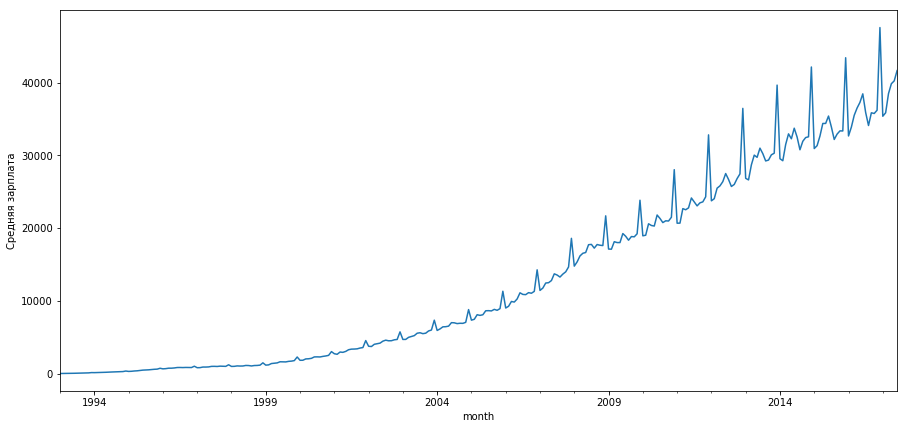

In [3]:
plt.figure(figsize(15,7))
data.wage.plot()
plt.ylabel(u'Средняя зарплата')
pylab.show()

Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.995929


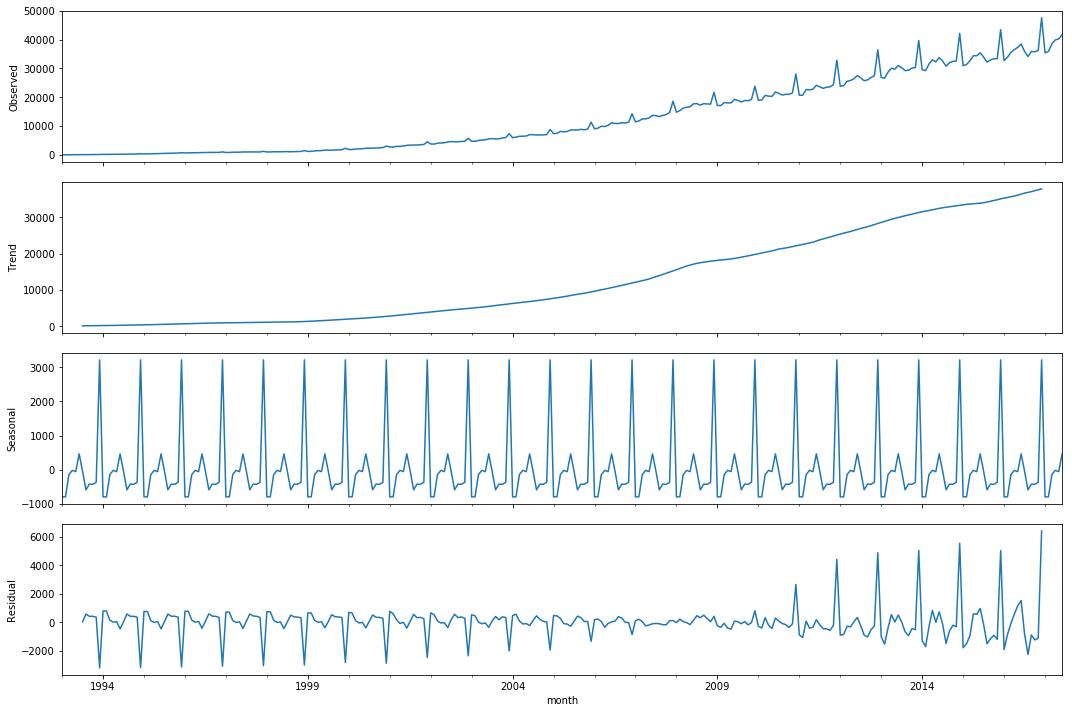

In [4]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.wage).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.wage)[1])

По критерию Дики-Фуллера гипотеза о нестационарности ряда не отвергается.

Сразу видны следующие особенности данных:
* возрастающий тренд
* растущая со временем дисперсия
* периодичность (период - 12 месяцев)
* заметная структура остатков

### Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.270218
Критерий Дики-Фуллера: p=0.719046


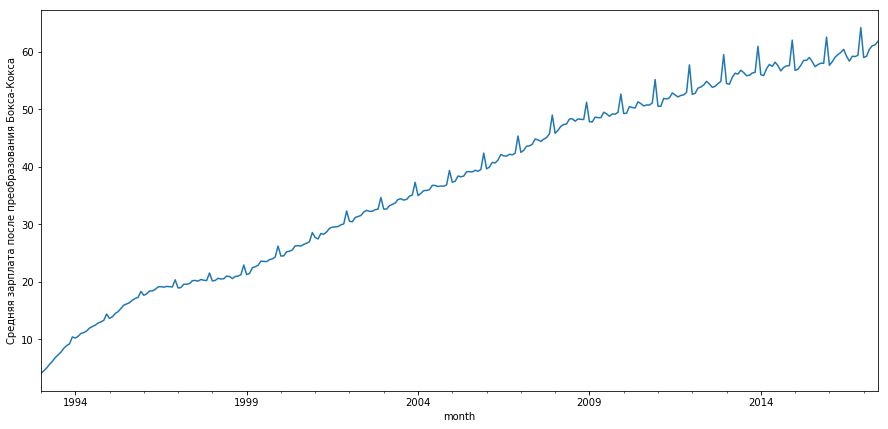

In [5]:
data['wage_box'], lmbda = stats.boxcox(data.wage)
plt.figure(figsize(15,7))
data.wage_box.plot()
plt.ylabel(u'Средняя зарплата после преобразования Бокса-Кокса')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.wage_box)[1])

Размах дисперсии ощутимо уменьшился.

По критерию Дики-Фуллера нулевая гипотеза о нестационарности ряда не отвергается (0.72 > 0.05)

### Стационарность

Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.009562


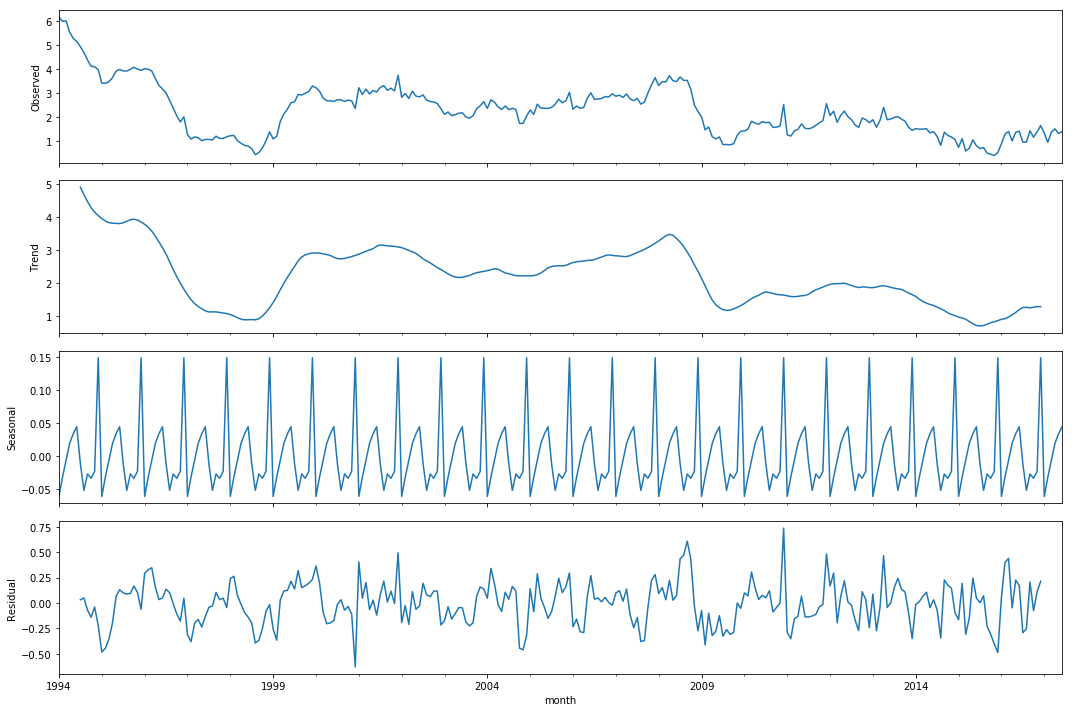

In [6]:
data['wage_box_diff'] = data.wage_box - data.wage_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.wage_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.wage_box_diff[12:])[1])

По критерию Дики-Фуллера можно отвергнеть гипотезу нестационарности (0.009 < 0.05), в остатках стало заметно меньше структуры, но полностью избавиться от тренда не удалось. Попробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000000


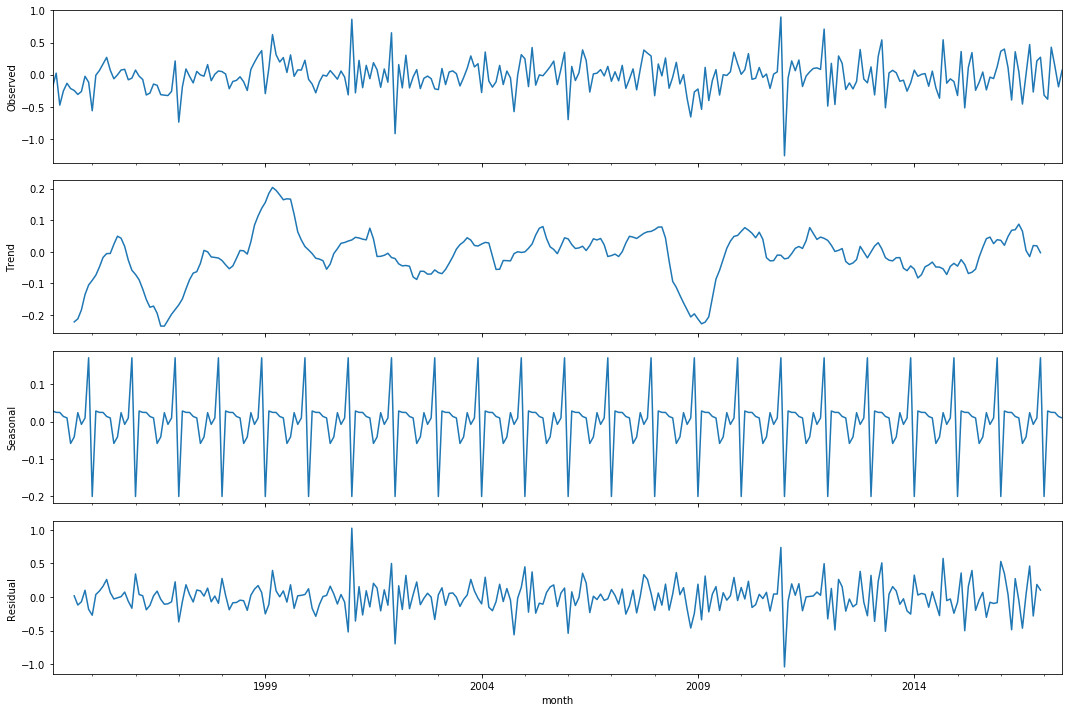

In [7]:
data['wage_box_diff2'] = data.wage_box_diff - data.wage_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.wage_box_diff2[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.wage_box_diff2[13:])[1])

Гипотеза нестационарности отвергается, остатки выглядят похоже на белый шум, и явного тренда больше нет. 

## Подбор модели

Посмотрим на ACF и PACF полученного ряда:

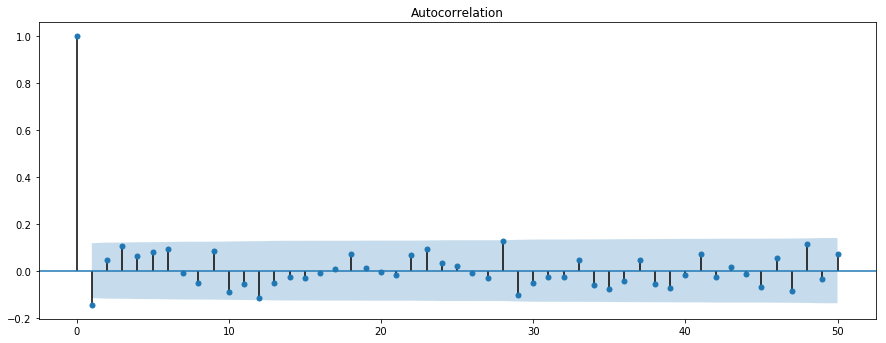

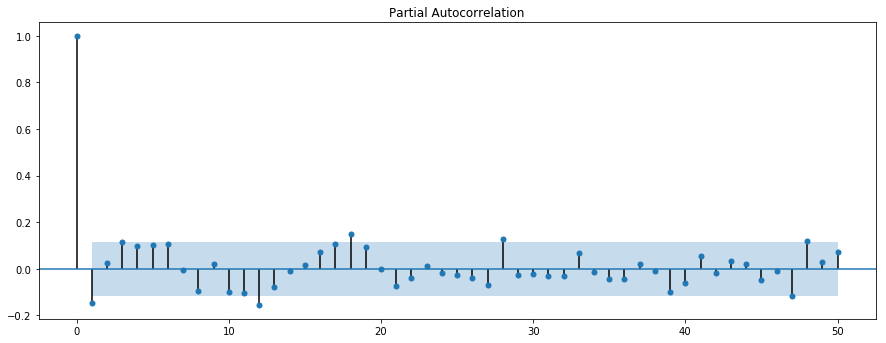

In [8]:
plt.figure(figsize(15,12))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.wage_box_diff2[13:].values.squeeze(), lags=50, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.wage_box_diff2[13:].values.squeeze(), lags=50, ax=ax)
pylab.show()

Выбираем параметры нашей модели:

__Q__ - значение последнего значимого сезонного лага на автокоррелограмме. Т.к. значимых лагов, кратных периоду (12) нет, то __Q = 0__

__q__ - значение последнего значимого несезонного лага на автокоррелограмме. __q = 1__

__P__ - значение последнего значимого сезонного лага на частичной автокоррелограмме. В данном случае это лаг = 12, поэтому возьмем значение __P = 1__

__p__ - значение последнего значимого несезонного лага, меньшего величин периода, на частичной автокоррелограмме. __p = 1__


Начальные приближения: Q=0, q=1, P=1, p=1

In [9]:
#устанавливаем границы массивов наших параметров согласно начальным приближениям
ps = range(0, 2)
d=1
qs = range(0, 2)
Ps = range(0, 2)
D=1
Qs = range(0, 1)

In [10]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

8

In [11]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.wage_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

('wrong parameters:', (0, 0, 0, 0))
Wall time: 1.58 s


Выводим удачные модели:

In [12]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

     parameters        aic
4  (1, 0, 1, 0)  36.753491
2  (0, 1, 1, 0)  37.356642
6  (1, 1, 1, 0)  38.745133
3  (1, 0, 0, 0)  40.310501
1  (0, 1, 0, 0)  40.901350


Лучшая модель:

In [13]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                           wage_box   No. Observations:                  294
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                 -15.377
Date:                            Thu, 17 Aug 2017   AIC                             36.753
Time:                                    22:58:42   BIC                             47.804
Sample:                                01-01-1993   HQIC                            41.179
                                     - 06-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1643      0.045     -3.633      0.000      -0.253      -0.076
ar.S.L12      -0.1471      0.045   

Рассмотрим остатки модели:

Критерий Стьюдента: p=0.136760
Критерий Дики-Фуллера: p=0.000070


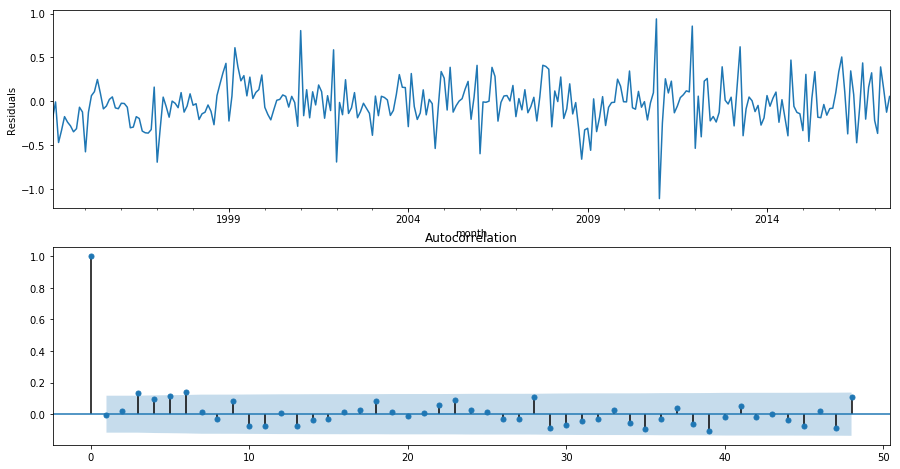

In [14]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

* Критерией Стьюдента: p = 0.137 > 0.05 - __остатки несмещены __
* Критерий Дики-Фуллера: p < 0.05 - __остатки стационарны__
* Критерий Льюнга-Бокса: p = 0.12 > 0.05 - __остатки неавтокоррелированы__

Однако, уровни значимости критерия Льюинг-Бокса и критерия Стьюдента не слишком велики. Возможно, стоит перебрать больше значений параметров для поиска оптимальной модели?

In [15]:
ps = range(0, 4)
d=1
qs = range(0, 4)
Ps = range(0, 2)
D=1
Qs = range(0, 2)
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

64

In [16]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.wage_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

('wrong parameters:', (0, 0, 0, 0))
('wrong parameters:', (1, 2, 0, 0))
('wrong parameters:', (1, 2, 0, 1))
('wrong parameters:', (1, 2, 1, 0))
('wrong parameters:', (1, 2, 1, 1))
('wrong parameters:', (2, 1, 0, 0))
('wrong parameters:', (2, 1, 0, 1))
('wrong parameters:', (2, 1, 1, 0))
('wrong parameters:', (2, 1, 1, 1))
('wrong parameters:', (2, 2, 0, 0))
('wrong parameters:', (2, 2, 0, 1))
('wrong parameters:', (2, 2, 1, 0))
('wrong parameters:', (2, 2, 1, 1))
('wrong parameters:', (2, 3, 0, 0))
('wrong parameters:', (2, 3, 0, 1))
('wrong parameters:', (2, 3, 1, 0))
('wrong parameters:', (2, 3, 1, 1))
('wrong parameters:', (3, 2, 0, 0))
('wrong parameters:', (3, 2, 0, 1))
('wrong parameters:', (3, 2, 1, 0))
('wrong parameters:', (3, 2, 1, 1))
('wrong parameters:', (3, 3, 0, 0))
('wrong parameters:', (3, 3, 0, 1))
('wrong parameters:', (3, 3, 1, 0))
('wrong parameters:', (3, 3, 1, 1))
Wall time: 27.5 s


In [17]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters        aic
25  (1, 3, 1, 0)  24.265918
26  (1, 3, 1, 1)  25.006893
24  (1, 3, 0, 1)  25.348458
37  (3, 1, 1, 0)  30.594653
38  (3, 1, 1, 1)  31.276221


Как видно, действительно удалось найти модель с лучшим рейтингом Акаики (24.27 < 36.75), хоть и более сложную

In [18]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                           wage_box   No. Observations:                  294
Model:             SARIMAX(1, 1, 3)x(1, 1, 0, 12)   Log Likelihood                  -6.133
Date:                            Thu, 17 Aug 2017   AIC                             24.266
Time:                                    22:59:54   BIC                             46.367
Sample:                                01-01-1993   HQIC                            33.117
                                     - 06-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7711      0.117      6.567      0.000       0.541       1.001
ma.L1         -1.0123      0.122   

Рассмотрим остатки новой модели:

Критерий Стьюдента: p=0.363741
Критерий Дики-Фуллера: p=0.000000


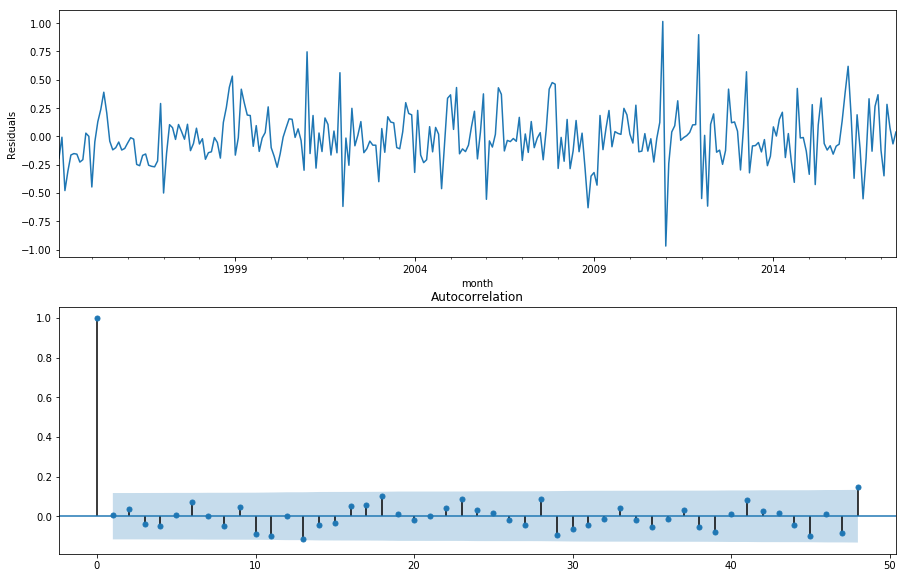

In [19]:
plt.figure(figsize(15,10))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Проверяем критерии:
* Критерией Стьюдента: p = 0.364 > 0.05 - __остатки несмещены __
* Критерий Дики-Фуллера: p < 0.05 - __остатки стационарны__
* Критерий Льюнга-Бокса: p = 0.64 > 0.05 - __остатки неавтокоррелированы__

Теперь посмотрим, как модель приближает данные.

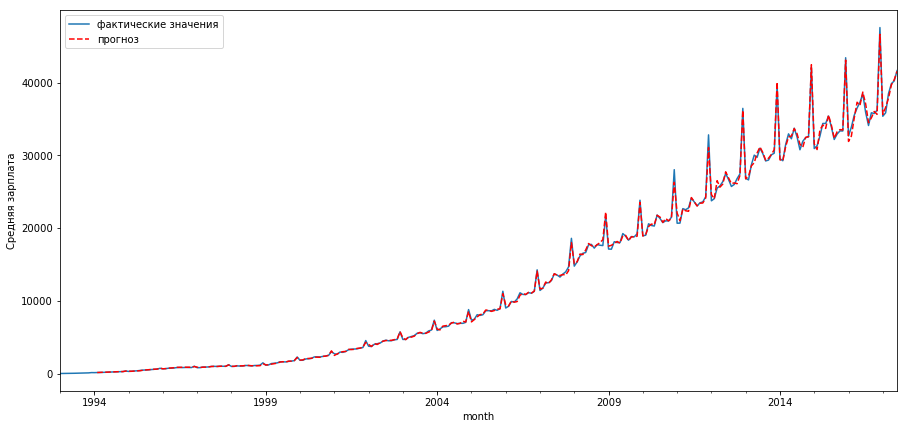

In [20]:
data['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
data.wage.plot(label = 'фактические значения')
data.model[13:].plot(color='r', label = 'прогноз', linestyle = '--')
plt.ylabel(u'Средняя зарплата')
plt.legend()
pylab.show()

Визуально наша модель неплохо приближает реальные данные. Посмотрим прогноз.

### Прогноз

In [21]:
#подбираем значения индексов для прогноза
best_model.predict(start=294, end=294 + 24)

2017-07-01    60.780473
2017-08-01    59.927822
2017-09-01    60.697635
2017-10-01    60.719783
2017-11-01    60.898897
2017-12-01    65.684251
2018-01-01    60.530058
2018-02-01    60.837025
2018-03-01    61.975889
2018-04-01    62.556001
2018-05-01    62.766139
2018-06-01    63.361614
2018-07-01    62.272978
2018-08-01    61.418710
2018-09-01    62.204081
2018-10-01    62.213665
2018-11-01    62.399555
2018-12-01    67.194234
2019-01-01    62.026696
2019-02-01    62.318104
2019-03-01    63.473045
2019-04-01    64.057850
2019-05-01    64.260315
2019-06-01    64.858290
2019-07-01    63.773953
Freq: MS, dtype: float64

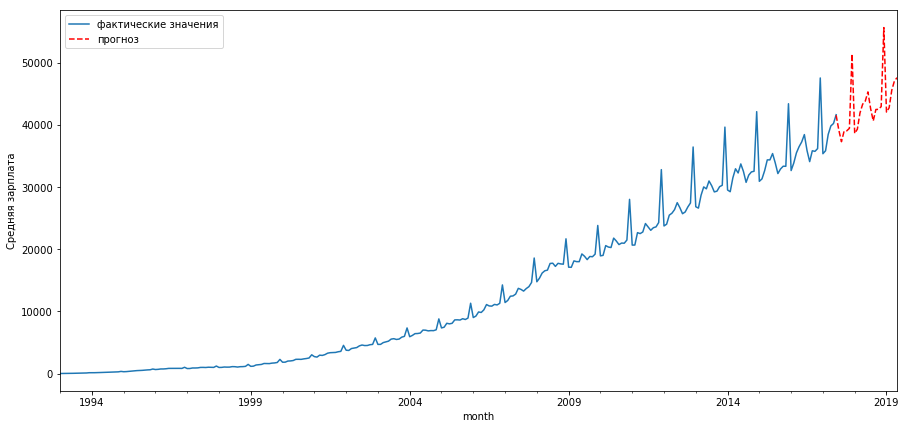

In [22]:
#Выводим прогноз
data2 = data[['wage']]
date_list = [datetime.datetime.strptime("2017-06-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns= data2.columns)
data2 = pd.concat([data2, future])
data2['forecast'] = invboxcox(best_model.predict(start=293, end=294 + 24), lmbda)

plt.figure(figsize(15,7))
data.wage.plot(label = 'фактические значения')
data2.forecast.plot(color='r', label = 'прогноз', linestyle = '--')
plt.ylabel(u'Средняя зарплата')
plt.legend()
pylab.show()

Видно, что прогноз учитывает как сезонные колебания в данных, так и возрастающий тренд. Прогноз выглядит адекватно.